In [23]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [25]:
json_file = "/Users/my475/OneDrive/Desktop/aave-wallet-credit-score/user-wallet-transactions.json"  # Your downloaded file

print("Loading JSON Data...")
with open(json_file, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
print(f"✅ Loaded {len(df)} transactions from file.")


Loading JSON Data...
✅ Loaded 100000 transactions from file.


In [26]:
def get_amount(x):
    try:
        return float(x.get('amount', 0))
    except:
        return 0.0

df['amount'] = df['actionData'].apply(get_amount)


In [27]:
grouped = df.groupby(['userWallet', 'action']).agg(
    total_amount=('amount', 'sum'),
    transaction_count=('amount', 'count')
).reset_index()

# Pivot to get actions as columns
pivot_amount = grouped.pivot(index='userWallet', columns='action', values='total_amount').fillna(0)
pivot_count = grouped.pivot(index='userWallet', columns='action', values='transaction_count').fillna(0)

# Combine both into one dataframe
features = pivot_amount.add_suffix('_amount').join(pivot_count.add_suffix('_count'))

In [28]:
features['total_deposit'] = features.get('deposit_amount', 0)
features['total_borrow'] = features.get('borrow_amount', 0)
features['total_repay'] = features.get('repay_amount', 0)
features['total_liquidations'] = features.get('liquidationcall_count', 0)

# Ratios
features['repayment_ratio'] = np.where(
    features['total_borrow'] == 0, 0, features['total_repay'] / features['total_borrow']
)
features['deposit_borrow_ratio'] = np.where(
    features['total_borrow'] == 0, 0, features['total_deposit'] / features['total_borrow']
)

features = features.fillna(0)


In [29]:
features['raw_score'] = (
    (features['total_deposit'] * 0.3) +
    (features['repayment_ratio'] * 500 * 0.3) +
    (features['deposit_borrow_ratio'] * 0.2) -
    (features['total_liquidations'] * 100 * 0.2) -
    (features['total_borrow'] * 0.1)
)

# ✅ Convert raw_score to float (very important)
features['raw_score'] = pd.to_numeric(features['raw_score'], errors='coerce').fillna(0).astype(float)

# Normalize to range 0–1000
raw_scores = features[['raw_score']].copy()
if raw_scores['raw_score'].nunique() <= 1:
    features['credit_score'] = 500
else:
    scaler = MinMaxScaler(feature_range=(0, 1000))
    features['credit_score'] = scaler.fit_transform(raw_scores)


In [30]:
output = features[['credit_score', 'raw_score']].reset_index()
output.to_csv("wallet_credit_scores.csv", index=False)
print("✅ Credit scores saved to wallet_credit_scores.csv")

✅ Credit scores saved to wallet_credit_scores.csv


Model-Based Credit Scoring (Regression or Classification)(optionl)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Example (regression)
X = features.drop(columns=['raw_score', 'credit_score'])
y = features['credit_score']  # or use 'raw_score'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))


MSE: 4.663136147944226


Clustering Wallets (Unsupervised Learning)(optional)

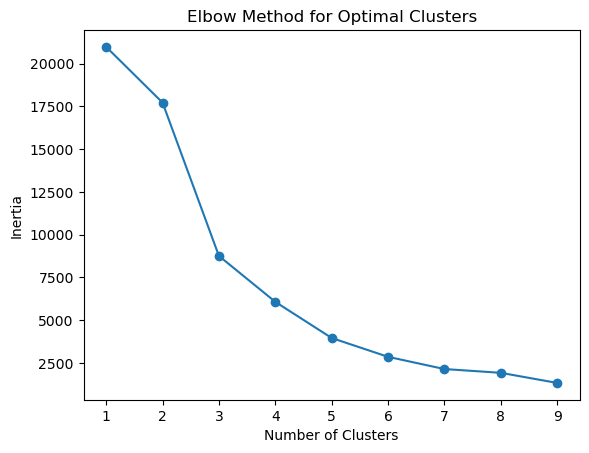

In [40]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Use behavioral features only
clustering_features = features[[
    'total_deposit', 'total_borrow', 'total_repay',
    'total_liquidations', 'repayment_ratio', 'deposit_borrow_ratio'
]]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_features)

# Choose number of clusters using Elbow Method
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply clustering
kmeans = KMeans(n_clusters=3, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)
